## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******


## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
co = cptac.Colon()
proteomics = co.get_proteomics()
transcriptomics = co.get_transcriptomics()
clinical = co.get_clinical()

Checking that data files are up-to-date...
100% [..................................................................................] 487 / 487
Data check complete.
colon data version: Most recent release

Loading clinical data...
Loading miRNA data...
Loading mutation data...
Loading mutation_binary data...
Loading phosphoproteomics_normal data...
Loading phosphoproteomics_tumor data...
Loading proteomics_normal data...
Loading proteomics_tumor data...
Loading transcriptomics data...


## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [3]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())

In [4]:
annotations = annotations.drop(['Patient_ID'], axis=1)

In [5]:
already_binary_columns = ['Mutation_Phenotype', 'Tumor.Status', 
                          'Vital.Status', 'Polyps_Present', 
                          'Polyps_History', 'Synchronous_Tumors', 
                          'Perineural_Invasion', 'Lymphatic_Invasion', 
                          'Vascular_Invasion', 'Mucinous', 'Gender', 
                          'Sample_Tumor_Normal']

#should pathalogy_T_stage be pathology_T_stage??
columns_2_binarize = ['Age', 'Subsite', 
                      'pathalogy_T_stage',
                      'pathalogy_N_stage', 
                      'Stage', 'CEA', 
                      'Transcriptomic_subtype', 
                      'Proteomic_subtype', 
                      'mutation_rate']

## Step 2a: Binarize column values

Clean up columns that are strings, that should be numerics

In [6]:
clinical['CEA'] = pd.to_numeric(clinical['CEA'])
clinical['Age'] = pd.to_numeric(clinical['Age'])
clinical['mutation_rate'] = pd.to_numeric(clinical['mutation_rate'])

In [7]:
annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       730, '2 years or older', 
                                       'Younger than 2 years')

In [8]:
subsite_map = {'Sigmoid Colon':'Sigmoid_Colon', 
               'Ascending Colon':'Other_site', 
               'Cecum ':'Other_site', 
               'Descending Colon':'Other_site', 
               'Hepatix Flexure':'Other_site', 
               'Splenic Flexure':'Other_site', 
               'Tranverse Colon':'Other_site'}

annotations['Subsite'] = bf.binarizeCategorical(clinical, 
                                                'Subsite', 
                                                subsite_map)

In [9]:
pathalogy_T_stage_map = {'T3':'T3orT2', 'T2':'T3orT2', 
                         'T4a':'T4', 'T4b':'T4'}

annotations['pathalogy_T_stage'] = bf.binarizeCategorical(clinical, 
                                                          'pathalogy_T_stage', 
                                                          pathalogy_T_stage_map)

In [10]:
pathalogy_N_stage_map = {'N0':'N0', 'N1':'N1orN2',
                         'N1a':'N1orN2', 'N1b':'N1orN2', 
                         'N2a':'N1orN2', 'N2b':'N1orN2'}

annotations['pathalogy_N_stage'] = bf.binarizeCategorical(clinical, 
                                                          'pathalogy_N_stage', 
                                                          pathalogy_N_stage_map)

In [11]:
stage_map = {'Stage I':'StageIorII', 
             'Stage II':'StageIorII', 
             'Stage III':'StageIIIorIV', 
             'Stage IV':'StageIIIorIV'}

annotations['Stage'] = bf.binarizeCategorical(clinical, 
                                              'Stage', 
                                              stage_map)

In [12]:
annotations['CEA'] = bf.binarizeCutOff(clinical, 
                                       'CEA', 15, 
                                       'High_CEA', 
                                       'Low_CEA')

In [13]:
Transcriptomic_subtype_map = {'CMS1':'CMS1or2', 
                              'CMS2':'CMS1or2', 
                              'CMS3':'CMS3or4', 
                              'CMS4':'CMS3or4'}

annotations['Transcriptomic_subtype'] = bf.binarizeCategorical(clinical, 
                                                               'Transcriptomic_subtype', 
                                                               Transcriptomic_subtype_map)

In [14]:
Proteomic_subtype_map = {'A':'AorBorC', 
                         'B':'AorBorC', 
                         'C':'AorBorC', 
                         'D':'DorE', 
                         'E':'DorE'}

annotations['Proteomic_subtype'] = bf.binarizeCategorical(clinical, 
                                                          'Proteomic_subtype', 
                                                          Proteomic_subtype_map)

In [15]:
annotations['mutation_rate'] = bf.binarizeCutOff(clinical, 
                                                 'mutation_rate', 50, 
                                                 'High_Mutation_Rate', 
                                                 'Low_Mutation_Rate')

## Step 3: Perform outliers analysis

In [16]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_trans = blsh.make_outliers_table(transcriptomics, iqrs=1.5, 
                                          up_or_down='up', 
                                          aggregate=False, 
                                          frac_table=False)

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [19]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

Testing 2 rows for enrichment in Age 2 years or older samples
Testing 4 rows for enrichment in Age Younger than 2 years samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Normal samples
Testing 2 rows for enrichment in Gender Female samples
Testing 3 rows for enrichment in Gender Male samples
Testing 1 rows for enrichment in Mucinous Not Mucinous samples
Testing 54 rows for enrichment in Mucinous Mucinous samples
Testing 3 rows for enrichment in Subsite Other_site samples
Testing 5 rows for enrichment in Subsite Sigmoid_Colon samples
No rows had outliers in at least 0.3 of pathalogy_T_stage T3orT2 samples
Testing 43 rows for enrichment in pathalogy_T_stage T4 samples
Testing 2 rows for enrichment in pathalogy_N_stage N0 samples
Testing 5 rows for enrichment in pathalogy_N_stage N1orN2 samples
Testing 4 rows for enrichment in Stage StageIIIorIV samples
Testing 3 rows for enrichment in Stage StageI

In [20]:
results_trans = blsh.compare_groups_outliers(outliers_trans, 
                                             annotations)

No rows had outliers in at least 0.3 of Age 2 years or older samples
Testing 2 rows for enrichment in Age Younger than 2 years samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of Gender Female samples
No rows had outliers in at least 0.3 of Gender Male samples
No rows had outliers in at least 0.3 of Mucinous Not Mucinous samples
No rows had outliers in at least 0.3 of Mucinous Mucinous samples
No rows had outliers in at least 0.3 of Subsite Other_site samples
No rows had outliers in at least 0.3 of Subsite Sigmoid_Colon samples
No rows had outliers in at least 0.3 of pathalogy_T_stage T3orT2 samples
Testing 1 rows for enrichment in pathalogy_T_stage T4 samples
No rows had outliers in at least 0.3 of pathalogy_N_stage N0 samples
No rows had outliers in at least 0.3 of pathalogy_N_stage N1orN2 samples
No rows had outliers in at least 0.3 of Stag

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [21]:
results_prot = results_prot.dropna(axis=0, how='all')
results_trans = results_trans.dropna(axis=0, how='all')

In [32]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.025)
    if sig_col is not None:
        sig_cols.append(sig_col)
    else:
        results_prot.drop()

TESTING FOR PROTEOMICS:
1 significant protein enrichment in Age_Younger than 2 years:

1 significant protein enrichment in Gender_Female:

5 significant protein enrichments in Mucinous_Mucinous

2 significant protein enrichments in Subsite_Other_site

1 significant protein enrichment in Subsite_Sigmoid_Colon:

1 significant protein enrichment in pathalogy_N_stage_N1orN2:

1 significant protein enrichment in CEA_High_CEA:

1 significant protein enrichment in Vascular_Invasion_Yes:

2 significant protein enrichments in Lymphatic_Invasion_Yes

1 significant protein enrichment in Synchronous_Tumors_Yes:

1 significant protein enrichment in Polyps_History_Yes:

2 significant protein enrichments in Polyps_Present_No

1 significant protein enrichment in Polyps_Present_Yes:

1 significant protein enrichment in Transcriptomic_subtype_CMS1or2:

3 significant protein enrichments in Proteomic_subtype_AorBorC

8 significant protein enrichments in Proteomic_subtype_DorE

107 significant protein enri

## Step 5: Visualize these enrichments

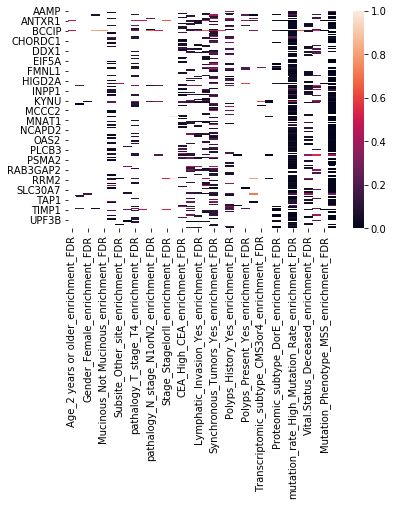

In [22]:
sns.heatmap(results_prot)
plt.show()

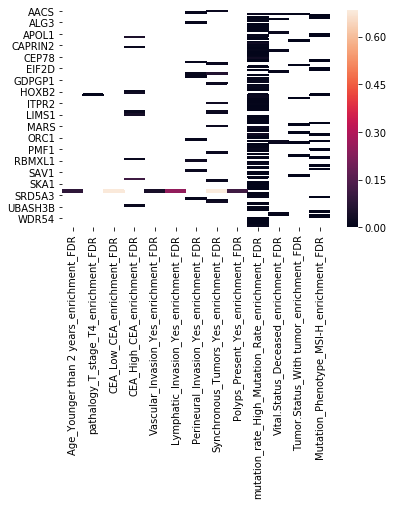

In [23]:
sns.heatmap(results_trans)
plt.show()

In [ ]:
#How can we automate something like this?
'''results_prot = results_prot.drop(['Proteomics_Tumor_Normal_Other_tumor_enrichment_FDR', 
                                  'Histologic_Grade_FIGO_High_grade_enrichment_FDR',
                                  'Histologic_Grade_FIGO_Low_grade_enrichment_FDR', 
                                  'Myometrial_invasion_Specify_50%_or_more_enrichment_FDR'], 
                                 axis=1)
'''

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [24]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.025)
    if sig_col is not None:
        sig_cols.append(sig_col)
    else:
        continue

TESTING FOR PROTEOMICS:
1 significant protein enrichment in Age_Younger than 2 years:

1 significant protein enrichment in Gender_Female:

5 significant protein enrichments in Mucinous_Mucinous

2 significant protein enrichments in Subsite_Other_site

1 significant protein enrichment in Subsite_Sigmoid_Colon:

1 significant protein enrichment in pathalogy_N_stage_N1orN2:

1 significant protein enrichment in CEA_High_CEA:

1 significant protein enrichment in Vascular_Invasion_Yes:

2 significant protein enrichments in Lymphatic_Invasion_Yes

1 significant protein enrichment in Synchronous_Tumors_Yes:

1 significant protein enrichment in Polyps_History_Yes:

2 significant protein enrichments in Polyps_Present_No

1 significant protein enrichment in Polyps_Present_Yes:

1 significant protein enrichment in Transcriptomic_subtype_CMS1or2:

3 significant protein enrichments in Proteomic_subtype_AorBorC

8 significant protein enrichments in Proteomic_subtype_DorE

107 significant protein enri

In [29]:
for col in sig_cols:
    if len(col) > 10:
        print(col)

          mutation_rate_High_Mutation_Rate_P_values
ADGRE5                                     0.007492
ANP32E                                     0.007491
APOBEC3G                                   0.006239
ARHGEF2                                    0.021768
ATP6V1A                                    0.021768
ATP6V1E1                                   0.008704
BPI                                        0.021768
CBFB                                       0.019409
CDC73                                      0.007491
CDCP1                                      0.006239
CHORDC1                                    0.001451
COL4A3BP                                   0.013266
CYBB                                       0.021768
DNAJC1                                     0.008704
EIF3H                                      0.017372
EIF5A                                      0.007491
EXOSC4                                     0.006239
EXOSC6                                     0.013266
EXOSC7      

In [25]:
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/enrichr_kegg', #This isn't saving correctly...why is that?
                            cutoff=0.5)
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2
